**Тестовое задание  для проекта мастерской по виртуальным платформенным решениям Зениной Алёны**
## Скачиваю датасет с kaggle
Скачиваю с помощью личного API-токена, поэтому нужен файл kaggle.json, чтобы следующий код работал, либо загрузить датасет вручную

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d hlrhegemony/pokemon-image-dataset

 97% 56.0M/57.9M [00:03<00:00, 23.2MB/s]
100% 57.9M/57.9M [00:03<00:00, 16.8MB/s]


In [ ]:
%%capture
! unzip pokemon-image-dataset.zip

Для генерации изображений буду использовать архитектуру Deep Convolutional Generative Adversarial Nets (DCGAN)
## Импорты, гиперпараметры и тд.

In [ ]:
import os
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
# Задаю девайс
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Путь до датасета
dataroot = "/content/images"

# Количество подпроцессов для даталоадера
workers = 2

# Размер батча
batch_size = 32

# Пространственный размер изображений для трансформатора
image_size = 64

# Количество каналов в изображениях (для цветного)
nc = 3

# Размер скрытого вектора z (размер инпута генератора)
nz = 100

# Размер feature maps в генераторе DCGAN
ngf = 64

# Размер feature maps в дискриминаторе DCGAN
ndf = 64

# Количество эпох
num_epochs = 200

# Learning rate для оптимизатора
lr = 0.0002

# Beta1 гиперпараметр для Adam
beta1 = 0.5

# Количество доступных gpu
ngpu = 1

## Обрабатываю и визуализирую картинки из датасета

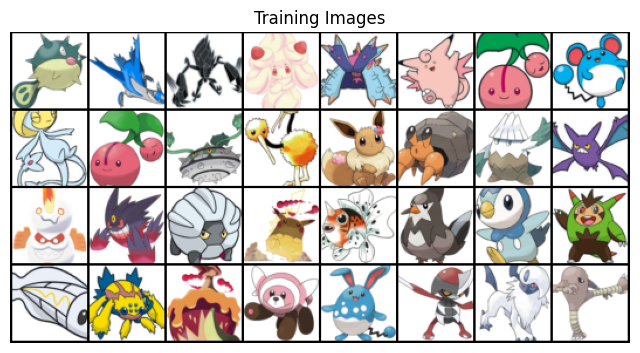

In [ ]:
# Создаю датасет с трансформированными изображениями

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Создаю даталоадер
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Девайс
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Визуаилизирую некоторые изображения из датасета
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Архитектура модели

In [ ]:
# Функция для инициализации весов
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Генератор (генерирует изображения на основе приближения распределения данных)
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Создаю генератор
netG = Generator(ngpu).to(device)

# Использую несколько графических процессоров
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Инициализирую начальные веса
netG.apply(weights_init)

# Модель
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Дискриминатор (оценивает вероятность, что образец пришел из тренировочных данных, а не сгенерирован генератором)
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Создаю дискриминатор
netD = Discriminator(ngpu).to(device)

# Использую несколько графических процессоров
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Инициализирую начальные веса
netD.apply(weights_init)

# Модель
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Инициализирую BCELoss function
criterion = nn.BCELoss()

# Батч векторов, который используется для визуализации прогрессии генератора
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Лейблы
real_label = 1
fake_label = 0

# Adam optimizer для генератора и дискриминатора
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Обучение модели

In [ ]:
# Списки, чтобы отслеживать процесс обучения
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# Эпоха
for epoch in range(num_epochs):
    # Батч
    for i, data in enumerate(dataloader, 0):

        ############################
        # Обновления дискриминатора: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Обучение с настоящими батчами
        netD.zero_grad()
        # Редактирую батч
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device).float()
        # Прямой проход по реальным батчам
        output = netD(real_cpu).view(-1)
        # Считаю loss на реальных батчах
        errD_real = criterion(output, label)
        # Считаю градиент для дискриминатора при обратном проходе
        errD_real.backward()
        D_x = output.mean().item()

        ## Обучение с фейковыми батчами
        # Генерирую батч скртытх векторов
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Генерирую фейковые изображения с помощью генератора
        fake = netG(noise)
        label.fill_(fake_label)
        # Классифициркю все фейковые батчи
        output = netD(fake.detach()).view(-1)
        # Считаю D's loss на всех фейковых батчах
        errD_fake = criterion(output, label)
        # Считаю градиент для этого батча
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Добавляю градиенты с фейковых и реальных батчей
        errD = errD_real + errD_fake
        # Обновляю дискриминатор
        optimizerD.step()

        ############################
        # (2) Обновление генератора: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        # Еще один прямой проход по фейковым батчам
        output = netD(fake).view(-1)
        # Считаю G's loss на данном выходе
        errG = criterion(output, label)
        # Считаю градиент для генератора
        errG.backward()
        D_G_z2 = output.mean().item()
        # Обновляю генератор
        optimizerG.step()

        # Результаты по мере обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Сохраняю лоссы для отслеживания
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Проверка работы генератора
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/200][0/79]	Loss_D: 1.7163	Loss_G: 5.4623	D(x): 0.4429	D(G(z)): 0.4776 / 0.0048
[0/200][50/79]	Loss_D: 1.1880	Loss_G: 21.1862	D(x): 0.9486	D(G(z)): 0.5989 / 0.0000
[1/200][0/79]	Loss_D: 0.3326	Loss_G: 11.5671	D(x): 0.8034	D(G(z)): 0.0000 / 0.0000
[1/200][50/79]	Loss_D: 0.6546	Loss_G: 3.5407	D(x): 0.8474	D(G(z)): 0.3277 / 0.0390
[2/200][0/79]	Loss_D: 0.6348	Loss_G: 3.6643	D(x): 0.9071	D(G(z)): 0.3458 / 0.0473
[2/200][50/79]	Loss_D: 0.3440	Loss_G: 7.0490	D(x): 0.9668	D(G(z)): 0.2527 / 0.0015
[3/200][0/79]	Loss_D: 3.5435	Loss_G: 13.6622	D(x): 0.9966	D(G(z)): 0.9231 / 0.0000
[3/200][50/79]	Loss_D: 0.1400	Loss_G: 7.6545	D(x): 0.8988	D(G(z)): 0.0208 / 0.0017
[4/200][0/79]	Loss_D: 0.3730	Loss_G: 3.3563	D(x): 0.8887	D(G(z)): 0.1662 / 0.0703
[4/200][50/79]	Loss_D: 0.4798	Loss_G: 4.7517	D(x): 0.8768	D(G(z)): 0.2344 / 0.0138
[5/200][0/79]	Loss_D: 1.2969	Loss_G: 5.0404	D(x): 0.9029	D(G(z)): 0.5894 / 0.0124
[5/200][50/79]	Loss_D: 0.4696	Loss_G: 4.0184	D(x): 0.8513	D(G(z)

Модель обучилась достаточно быстро: ~7 минут
## Визуализация результатов

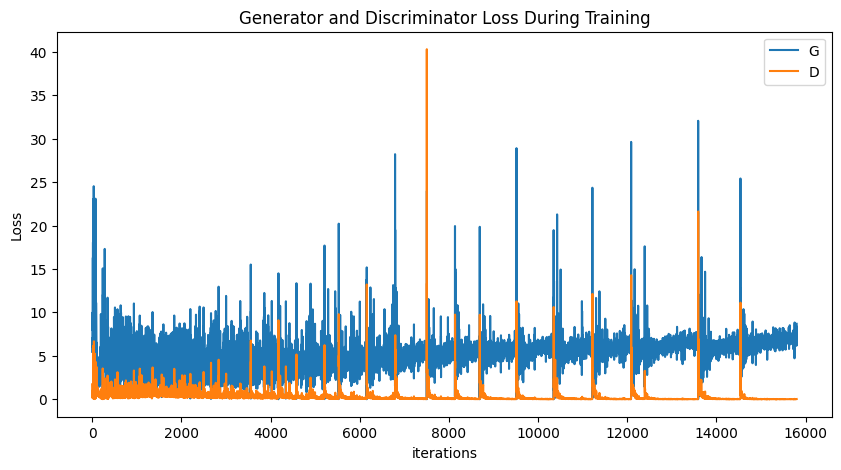

In [ ]:
# График лосов
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

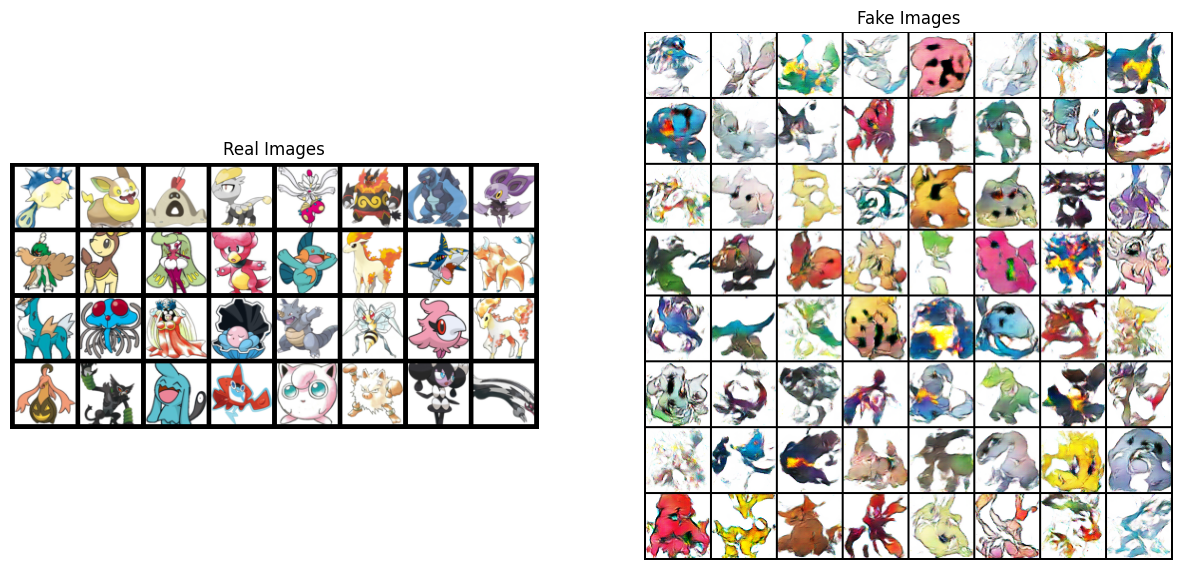

In [ ]:
# Беру батч изображений из датасета
real_batch = next(iter(dataloader))

# Визуализирую реальные изображения
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Визуализирую сгенерированные изображения из последней эпохи
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Сохраняю модель

In [ ]:
# Сохраняю в TorchScript
model_scripted = torch.jit.script(netG)
model_scripted.save('model_scripted.pt')

Я сохранила модель в формате .pt и выложила на [гитхаб](https://github.com/ssakk/pokemon_dcgan/raw/main/model), откуда ее можно скачать
## Скачивание и запуск предобученной модели

In [ ]:
!wget https://github.com/ssakk/pokemon_dcgan/raw/main/model/model_scripted.pt

--2024-02-05 20:54:36--  https://github.com/ssakk/pokemon_dcgan/raw/main/model/model_scripted.pt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ssakk/pokemon_dcgan/main/model/model_scripted.pt [following]
--2024-02-05 20:54:36--  https://raw.githubusercontent.com/ssakk/pokemon_dcgan/main/model/model_scripted.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14361492 (14M) [application/octet-stream]
Saving to: ‘model_scripted.pt.1’

model_scripted.pt.1 100%[===================>]  13.70M  --.-KB/s    in 0.04s   

2024-02-05 20:54:37 (312 MB/s) - ‘model_scripted.pt.1’ saved [14361492/14361492

In [ ]:
# Загрузка модели
saved_model = torch.jit.load('model_scripted.pt')
saved_model.eval()

RecursiveScriptModule(
  original_name=Generator
  (main): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=ConvTranspose2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=ConvTranspose2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=ConvTranspose2d)
    (7): RecursiveScriptModule(original_name=BatchNorm2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=ConvTranspose2d)
    (10): RecursiveScriptModule(original_name=BatchNorm2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=ConvTranspose2d)
    (13): RecursiveScriptModule(original_name=Tanh)
  )
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

with torch.no_grad():
    fake = saved_model(fixed_noise).detach().cpu()
    img = (vutils.make_grid(fake, padding=2, normalize=True))

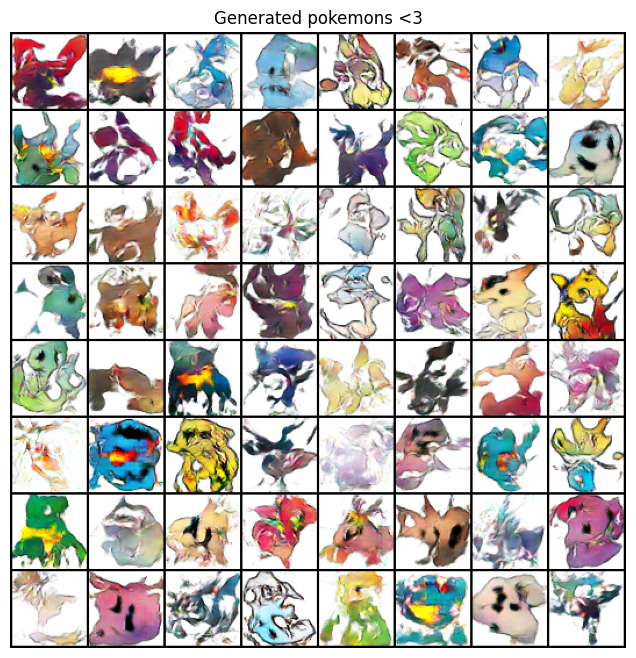

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated pokemons <3")
plt.imshow(np.transpose(img, (1,2,0)))

Получились вполне интересные и похожие на реальных покемонов кляксы, модель было бы интересно обучить и на большем количестве эпох и сравнить результаты (например, результат между 100 и 200 эпохами несильно отличается в пользу последнего)